# Filtering dataframe for fertility analysis

The following filtering steps are according to NAV, apart from choice of breeds. Edits are performed on "fertilityDF_W.csv" i.e. after "BuildingDataframe.ipynb" & "FertilityTraits.ipynb" have been run
- Add 305d MY from raw data and check missing MY records (a756bc39, 6d38bc90)
- Keep only data from SH and NRDC
- Keep only lactation 1-8 
- Make parity 1, 2, >=3 
- Records within 150 days from data extraction are excluded from the data set 
- Only the first 10 inseminations are accepted for CR 
- Age at first calving: 550d - 1100d 
- CI maximum 2 years for cows
- CFS 20 - 230d
- FLS max 365d

Putting thresholds on classical fertility traits according to NAV or µ+-2SD of respective trait
- CFI: 20-230
- CLI: 20+217
- FLI: 0-365
- CI: 301-730
- GL: 260-302

In [89]:
from datetime import timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

from fpdf import FPDF

In [117]:
# LOAD DATA
df3 = pd.read_csv("../Data/CowData/fertilityDF_W.csv", low_memory=False)

In [118]:
# Crude data distribution
print(f"No. observations in fertilityDF_W.csv.csv: {df3.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"Double check no. pregnancy checks in fertilityDF_W.csv: {test.shape}")
print(f'No. ins without pregnancy checks: {df3.shape[0] - test.shape[0]}')

test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in fertilityDF_W.csv: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in fertilityDF_W.csv: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in fertilityDF_W.csv: {test.shape}")

No. observations in fertilityDF_W.csv.csv: (7024, 67)
Double check no. pregnancy checks in fertilityDF_W.csv: (6909, 67)
No. ins without pregnancy checks: 115
No. inseminations in fertilityDF_W.csv: (4673, 67)
No. lactations in fertilityDF_W.csv: (2555, 67)
No. cows in fertilityDF_W.csv: (1516, 67)


Keep only herds with (MY_W) data

In [119]:
# Count number of inseminations in herds
ins_count = df3.groupby("FarmName_Pseudo")["InseminationDate"].count()
print(ins_count)

FarmName_Pseudo
5b581702     516
5c06d92d    2676
6d38bc90     255
a624fb9a     868
a756bc39     958
ad0a39f5    1461
f454e660     240
Name: InseminationDate, dtype: int64


In [120]:
# Count presence of HeatStress in the herds with issues with MY data
herds_to_keep = ['a756bc39', '6d38bc90']
df4 = df3[df3["FarmName_Pseudo"].isin(herds_to_keep)]

non_nan_count = df4['HeatStress'].notna().sum()
print(f"Number of non-NaN values: {non_nan_count}")

is_nan_count = df4['HeatStress'].isna().sum()
print(f"Number of NaN values: {is_nan_count}")


Number of non-NaN values: 974
Number of NaN values: 249


In [121]:
# Check if herds with issues with MY recording in DelPro have raw data from cow database
MY = pd.read_csv("C:/Users/pagd0001/Desktop/Gigacow/Data/20241009/Gigacow-tools/Projects/HeatStressEvaluation/Data/CowData/Kok_LactationReturn240820.csv", low_memory=False, delimiter=";")
col_keep = ["BirthID", "CalvingNumber", "Milk_Kg"]
MY = MY[col_keep]
MY.rename(columns={"BirthID": "SE_Number", "CalvingNumber": "LactationNumber"}, inplace=True)
MY = MY.drop_duplicates(subset=["SE_Number", "LactationNumber", "Milk_Kg"])

In [122]:
MY

,SE_Number,LactationNumber,Milk_Kg
0,SE-ad0a39f5-1831,2,14493
1,SE-ad0a39f5-1831,1,11931
2,SE-ad0a39f5-1831,3,14284
3,SE-ad0a39f5-1833,1,11432
4,SE-ad0a39f5-1834,1,10792
...,...,...,...
17648,SE-169e580a-5611,1,10820
17649,SE-169e580a-5612,1,8658
17650,SE-169e580a-5616,1,10720
17651,SE-ad0a39f5-2171,1,8469


In [123]:
# Add 305d MY records to fertilityDF_W.csv
df3 = pd.merge(df3, MY, on=["SE_Number", "LactationNumber"], how="left")
df3.to_csv("../Data/CowData/fertilityDF_W_MY.csv", index=False)
df3

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,last_preg_check,CR10,date_extraction,extraction_limit,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,False,NaN,2024-08-18,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,True,NaN,2024-08-18,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,False,0.0,2024-08-18,2024-03-21,NaN,733,NaN,10.0,1.0,NaN
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,False,0.0,2024-08-18,2024-03-21,NaN,733,NaN,30.0,1.0,NaN
4,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,True,0.0,2024-08-18,2024-03-21,NaN,733,NaN,30.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,SE-f454e660-0800,1.0,2023-12-30,2,NRDC,f454e660,800.0,5059.0,2021-08-24,SE-72d9fe50-7855,...,False,NaN,2024-08-18,2024-03-21,NaN,192,NaN,0.0,0.0,NaN
7020,SE-f454e660-0800,1.0,2024-02-08,1,NRDC,f454e660,800.0,5059.0,2021-08-24,SE-72d9fe50-7855,...,True,NaN,2024-08-18,2024-03-21,NaN,192,NaN,0.0,0.0,NaN
7021,SE-f454e660-0803,1.0,2023-12-07,1,DairyCross,f454e660,803.0,1732.0,2021-09-29,SE-458cc45c-7315,...,True,NaN,2024-08-18,2024-03-21,NaN,255,NaN,0.0,0.0,NaN
7022,SE-f454e660-0823,1.0,2024-03-26,1,SLB,f454e660,823.0,5352.0,2021-12-22,SE-344e5591-2011,...,True,NaN,2024-08-18,2024-03-21,NaN,145,NaN,0.0,0.0,NaN


In [124]:
# Count presence of 305d MY records in the herds with issues with MY data in DelPro
herds_to_keep = ['a756bc39', '6d38bc90']
df4 = df3[df3["FarmName_Pseudo"].isin(herds_to_keep)]

non_nan_count = df4['Milk_Kg'].notna().sum()
print(f"Number of non-NaN values: {non_nan_count}")

is_nan_count = df4['Milk_Kg'].isna().sum()
print(f"Number of NaN values: {is_nan_count}")

Number of non-NaN values: 811
Number of NaN values: 412


In [ ]:
""" =========================================================================>>> These herds have data reported to the cow database and can be included!
# Remove herds with missing MY records (a756bc39, 6d38bc90)
# Herds to remove
herds_to_remove = ['a756bc39', '6d38bc90']
df3 = df3[~df3['FarmName_Pseudo'].isin(herds_to_remove)]
"""

In [125]:
print(f"No. observations in fertilityDF_W_MY.csv.csv: {df3.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"Double check no. pregnancy checks in fertilityDF_W_MY.csv: {test.shape}")
print(f'No. ins without pregnancy checks: {df3.shape[0] - test.shape[0]}')

test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in fertilityDF_W_MY.csv: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in fertilityDF_W_MY.csv: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in fertilityDF_W_MY.csv: {test.shape}")

No. observations in fertilityDF_W_MY.csv.csv: (7024, 68)
Double check no. pregnancy checks in fertilityDF_W_MY.csv: (6909, 68)
No. ins without pregnancy checks: 115
No. inseminations in fertilityDF_W_MY.csv: (4673, 68)
No. lactations in fertilityDF_W_MY.csv: (2555, 68)
No. cows in fertilityDF_W_MY.csv: (1516, 68)


Data from SH and NRDC

In [126]:
# Keep only data from SH and NRDC
breeds_to_keep = ["NRDC", "SLB"]
df3 = df3[df3["Breed"].isin(breeds_to_keep)]

In [127]:
print(f"No. observations in file: {df3.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"Double check no. pregnancy checks in file: {test.shape}")
print(f'No. ins without pregnancy checks: {df3.shape[0] - test.shape[0]}')

test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in file: {test.shape}")

No. observations in file: (5527, 68)
Double check no. pregnancy checks in file: (5419, 68)
No. ins without pregnancy checks: 108
No. inseminations in file: (3709, 68)
No. lactations in file: (2007, 68)
No. cows in file: (1213, 68)


Allow for maximum lactation 1-8

In [128]:
# Distribution of lactations
check = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
value_counts = check['LactationNumber'].value_counts()
print(value_counts)

LactationNumber
1.0     720
2.0     555
3.0     368
4.0     207
5.0     102
6.0      36
7.0       9
8.0       6
9.0       2
10.0      2
Name: count, dtype: int64


In [129]:
# Keep only lactation 1-8
df3 = df3[df3["LactationNumber"] <= 8]

# No. lactations and cows in data
print(f"No. observations in file: {df3.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"Double check no. pregnancy checks in file: {test.shape}")
print(f'No. ins without pregnancy checks: {df3.shape[0] - test.shape[0]}')

test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in file: {test.shape}")

No. observations in file: (5513, 68)
Double check no. pregnancy checks in file: (5405, 68)
No. ins without pregnancy checks: 108
No. inseminations in file: (3700, 68)
No. lactations in file: (2003, 68)
No. cows in file: (1212, 68)


In [130]:
# Make Parity 1-3
df3 = df3.copy()
df3["Parity"] = df3["LactationNumber"]
df3.loc[(df3['LactationNumber'] >= 3) & (df3['LactationNumber'] <= 8), 'Parity'] = 3

Records within 150 days from data extraction are excluded from the data set (i.e. open records)

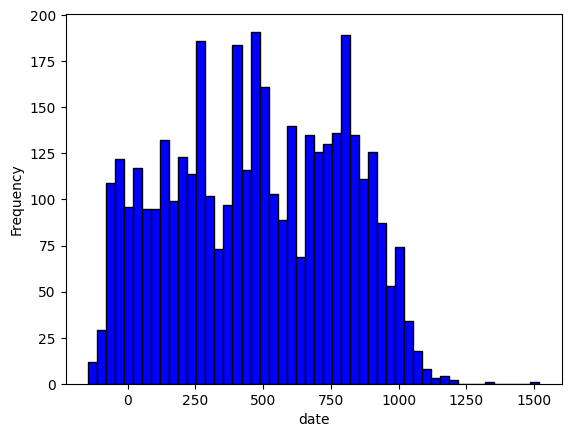

In [131]:
# Find open records
df3["extraction_limit"] = pd.to_datetime(df3["extraction_limit"])
df3["PregnancyCheckDate"] = pd.to_datetime(df3["PregnancyCheckDate"])

df3["open_rec"] = (df3["extraction_limit"] - df3["PregnancyCheckDate"]).dt.days

# Plot histogram
plt.hist(df3['open_rec'], bins=50, color='blue', edgecolor='black')
plt.xlabel('date')
plt.ylabel('Frequency')
plt.show()

In [132]:
df3 = df3[df3["open_rec"] > 150]

In [133]:
print(f"No. observations in file: {df3.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"Double check no. pregnancy checks in file: {test.shape}")
print(f'No. ins without pregnancy checks: {df3.shape[0] - test.shape[0]}')

test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in file: {test.shape}")

No. observations in file: (3234, 70)
Double check no. pregnancy checks in file: (3171, 70)
No. ins without pregnancy checks: 63
No. inseminations in file: (1800, 70)
No. lactations in file: (1525, 70)
No. cows in file: (990, 70)


Only keep first 10 ins

In [134]:
# Only the first 10 inseminations are accepted
# Distribution of NINS
value_counts = df3["NINS"].value_counts()
print(value_counts)

NINS
1     1375
2      972
3      495
4      200
5      110
6       46
8       14
7       11
9       10
13       1
Name: count, dtype: int64


In [135]:
# Count ins
df4 = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
df4

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,date_extraction,extraction_limit,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg,Parity,open_rec
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,3.0,914.0
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,3.0,547.0
12,SE-30dc5787-1389,5.0,2021-06-28,1,NRDC,a624fb9a,1389.0,12769.0,2015-01-27,SE-2725311b-7324,...,2024-08-18,2024-03-21,332.0,1147,NaN,NaN,NaN,11556.0,3.0,939.0
15,SE-30dc5787-1389,6.0,2022-06-18,2,NRDC,a624fb9a,1389.0,12769.0,2015-01-27,SE-2725311b-7324,...,2024-08-18,2024-03-21,379.0,749,NaN,8.0,1.0,11830.0,3.0,605.0
16,SE-30dc5787-1389,6.0,2022-07-31,1,NRDC,a624fb9a,1389.0,12769.0,2015-01-27,SE-2725311b-7324,...,2024-08-18,2024-03-21,379.0,749,NaN,18.0,1.0,11830.0,3.0,547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6986,SE-f454e660-0762,1.0,2023-06-02,1,SLB,f454e660,762.0,4388.0,2021-02-12,SE-458cc45c-6644,...,2024-08-18,2024-03-21,390.0,443,NaN,1.0,1.0,7368.0,1.0,239.0
6993,SE-f454e660-0768,1.0,2023-08-24,1,SLB,f454e660,768.0,2685.0,2021-02-25,SE-458cc45c-6498,...,2024-08-18,2024-03-21,451.0,360,NaN,10.0,1.0,11652.0,1.0,164.0
6994,SE-f454e660-0770,1.0,2023-08-08,1,SLB,f454e660,770.0,2514.0,2021-03-12,SE-458cc45c-6644,...,2024-08-18,2024-03-21,420.0,376,0.0,6.0,1.0,10541.0,1.0,178.0
7000,SE-f454e660-0785,1.0,2023-07-29,1,SLB,f454e660,785.0,10998.0,2021-05-28,SE-458cc45c-7429,...,2024-08-18,2024-03-21,390.0,386,0.0,9.0,1.0,10102.0,1.0,188.0


In [136]:
df3["InseminationDate"] = pd.to_datetime(df3["InseminationDate"])

df4 = df4.copy()
df4['InseminationDate'] = pd.to_datetime(df4['InseminationDate'])

df4['InsCount'] = df4.groupby(['SE_Number', 'LactationNumber']).cumcount() + 1
col_keep = ["SE_Number", "LactationNumber", "InseminationDate", "InsCount"]
df4 = df4[col_keep]

df5 = pd.merge(df3, df4, on=["SE_Number", "LactationNumber", "InseminationDate"], how="left")
df5

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,extraction_limit,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg,Parity,open_rec,InsCount
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,3.0,914.0,1
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,3.0,854.0,1
2,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,3.0,547.0,1
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,3.0,482.0,1
4,SE-30dc5787-1389,5.0,2021-06-28,1,NRDC,a624fb9a,1389.0,12769.0,2015-01-27,SE-2725311b-7324,...,2024-03-21,332.0,1147,NaN,NaN,NaN,11556.0,3.0,939.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,SE-f454e660-0768,1.0,2023-08-24,1,SLB,f454e660,768.0,2685.0,2021-02-25,SE-458cc45c-6498,...,2024-03-21,451.0,360,NaN,10.0,1.0,11652.0,1.0,164.0,1
3230,SE-f454e660-0770,1.0,2023-08-08,1,SLB,f454e660,770.0,2514.0,2021-03-12,SE-458cc45c-6644,...,2024-03-21,420.0,376,0.0,6.0,1.0,10541.0,1.0,178.0,1
3231,SE-f454e660-0785,1.0,2023-07-29,1,SLB,f454e660,785.0,10998.0,2021-05-28,SE-458cc45c-7429,...,2024-03-21,390.0,386,0.0,9.0,1.0,10102.0,1.0,188.0,1
3232,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,2024-03-21,344.0,356,NaN,18.0,1.0,8175.0,1.0,159.0,1


In [137]:
# Distribution of NINS ==========================================================>>> In this case have maximum 5 NINS, no further editing required
value_counts = df5["InsCount"].value_counts()
print(value_counts)

df5.to_csv("test.csv", index=False)

InsCount
1    2741
2     417
3      62
4      12
5       2
Name: count, dtype: int64


Age at first calving: 550d - 1100d 

In [ ]:
# Load raw data to get full calving history from cow database
dfkok = pd.read_csv("C:/Users/pagd0001/Desktop/Gigacow/Data/20241009/Gigacow-tools/Projects/HeatStressEvaluation/Data/CowData/Kok_Calving240820.csv", delimiter=";", low_memory=False)
col_keep = ["BirthID", "CalvingDate", "CalvingNumber"]
dfkok = dfkok[col_keep]
dfkok = dfkok.rename(columns={"BirthID": "SE_Number", "CalvingNumber": "LactationNumber"})
dfkok = dfkok.drop_duplicates(subset=["SE_Number", "LactationNumber"])
dfkok

,SE_Number,CalvingDate,LactationNumber
0,SE-6d38bc90-1383,2020-07-11,7
1,SE-6d38bc90-1383,2021-08-12,8
2,SE-6d38bc90-1384,2013-11-26,1
3,SE-6d38bc90-1384,2014-11-20,2
4,SE-6d38bc90-1384,2015-11-21,3
...,...,...,...
26472,SE-5b581702-1858,2021-01-10,1
26473,SE-5b581702-1858,2021-11-29,2
26474,SE-5b581702-1859,2021-02-11,1
26475,SE-5b581702-1859,2022-04-20,2


In [ ]:
# Load raw data to get BirthDate
bd = pd.read_csv("C:/Users/pagd0001/Desktop/Gigacow/Data/20241009/Gigacow-tools/Projects/HeatStressEvaluation/Data/CowData/Kok_Lineage240821.csv", delimiter=";", low_memory=False)
col_keep = ["BirthID", "BirthDate"]
bd = bd[col_keep]
bd = bd.rename(columns={"BirthID": "SE_Number"})
bd = bd.drop_duplicates(subset=["SE_Number"])
bd


,SE_Number,BirthDate
0,SE-6d38bc90-1772,2014-05-13
1,SE-6d38bc90-1774,2014-05-16
2,SE-6d38bc90-1775,2014-05-16
3,SE-6d38bc90-1776,2014-05-18
4,SE-6d38bc90-1777,2014-05-27
...,...,...
24062,SE-5b581702-1838,2018-07-28
24063,SE-5b581702-1839,2018-07-29
24064,SE-5b581702-1840,2018-08-03
24065,SE-5b581702-1841,2018-08-13


In [ ]:
# Combine
dfkok = pd.merge(dfkok, bd, on=["SE_Number"], how="left")

In [ ]:
# Calculate age at first calving
dfkok = dfkok[dfkok["LactationNumber"] == 1]
dfkok = dfkok.copy()
dfkok["BirthDate"] = pd.to_datetime(dfkok["BirthDate"])
dfkok["CalvingDate"] = pd.to_datetime(dfkok["CalvingDate"])
dfkok["AgeFirstCalving"] = (dfkok["CalvingDate"] - dfkok["BirthDate"]).dt.days

col_keep = ["SE_Number", "AgeFirstCalving"]
dfkok = dfkok[col_keep]
dfkok

,SE_Number,AgeFirstCalving
2,SE-6d38bc90-1384,763
9,SE-6d38bc90-1385,754
13,SE-6d38bc90-1387,1068
17,SE-6d38bc90-1392,844
22,SE-6d38bc90-1393,708
...,...,...
23666,SE-5b581702-1854,797
23669,SE-5b581702-1855,824
23673,SE-5b581702-1856,862
23676,SE-5b581702-1858,784


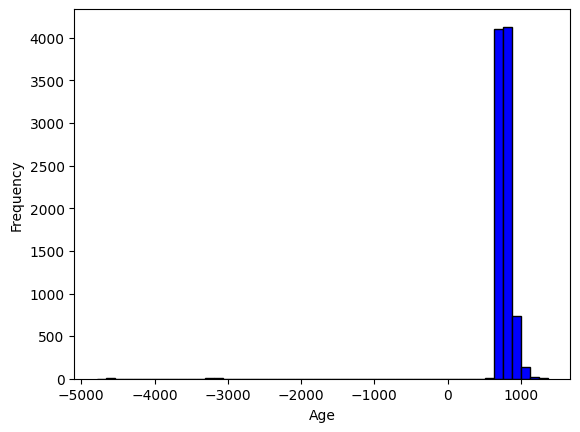

In [158]:
# Plot
plt.hist(dfkok['AgeFirstCalving'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [186]:
# Merge back onto current dataset
df6 = pd.merge(df5, dfkok, on=["SE_Number"], how="left")
df6

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg,Parity,open_rec,InsCount,AgeFirstCalving
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,328.0,1097,NaN,NaN,NaN,10208.0,3.0,914.0,1,786
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,328.0,1097,NaN,NaN,NaN,10208.0,3.0,854.0,1,786
2,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,733,NaN,30.0,1.0,NaN,3.0,547.0,1,786
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,733,NaN,30.0,1.0,NaN,3.0,482.0,1,786
4,SE-30dc5787-1389,5.0,2021-06-28,1,NRDC,a624fb9a,1389.0,12769.0,2015-01-27,SE-2725311b-7324,...,332.0,1147,NaN,NaN,NaN,11556.0,3.0,939.0,1,830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,SE-f454e660-0768,1.0,2023-08-24,1,SLB,f454e660,768.0,2685.0,2021-02-25,SE-458cc45c-6498,...,451.0,360,NaN,10.0,1.0,11652.0,1.0,164.0,1,709
3230,SE-f454e660-0770,1.0,2023-08-08,1,SLB,f454e660,770.0,2514.0,2021-03-12,SE-458cc45c-6644,...,420.0,376,0.0,6.0,1.0,10541.0,1.0,178.0,1,725
3231,SE-f454e660-0785,1.0,2023-07-29,1,SLB,f454e660,785.0,10998.0,2021-05-28,SE-458cc45c-7429,...,390.0,386,0.0,9.0,1.0,10102.0,1.0,188.0,1,646
3232,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,344.0,356,NaN,18.0,1.0,8175.0,1.0,159.0,1,701


In [187]:
non_nan_count = df6['AgeFirstCalving'].notna().sum()
print(f"Number of non-NaN values: {non_nan_count}")

is_nan_count = df6['AgeFirstCalving'].isna().sum()
print(f"Number of NaN values: {is_nan_count}")

Number of non-NaN values: 3234
Number of NaN values: 0


In [188]:
# Filter age at first calving keeping only inseminations from cows with an age between 550 and 1100days old
df6 = df6[df6['AgeFirstCalving'].between(550, 1100)]

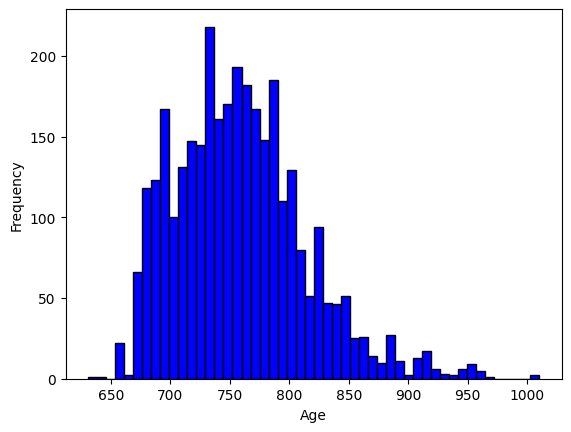

In [189]:
# Plot
plt.hist(df6['AgeFirstCalving'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [190]:
print(f"No. observations in file: {df6.shape}")

test = df6.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in file: {test.shape}")
test = df6.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in file: {test.shape}")
test = df6.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in file: {test.shape}")

No. observations in file: (3234, 72)
No. inseminations in file: (1800, 72)
No. lactations in file: (1525, 72)
No. cows in file: (990, 72)


Thresholds for classical fertility traits in editing full material (insemination wise)
- CI maximum 2 years for cows
- CFS 20 - 230d
- FLS max 365d

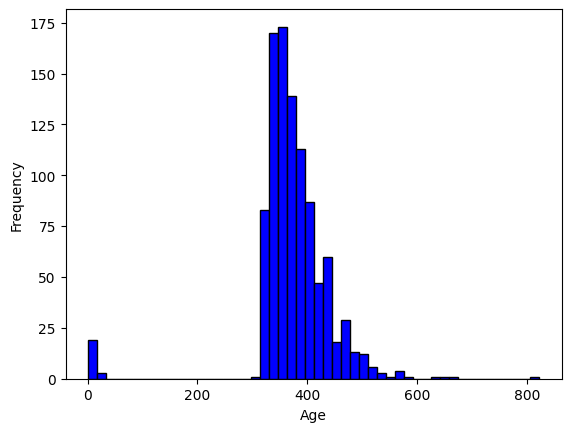

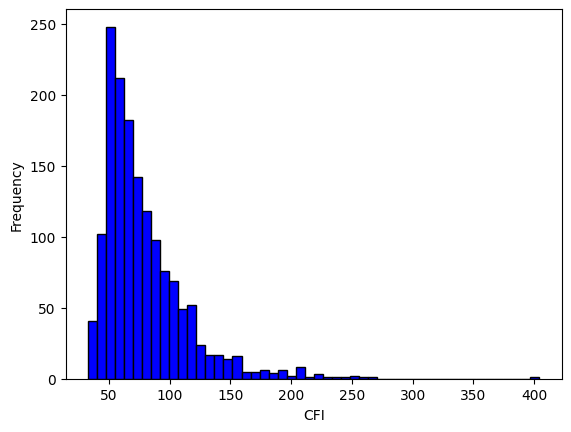

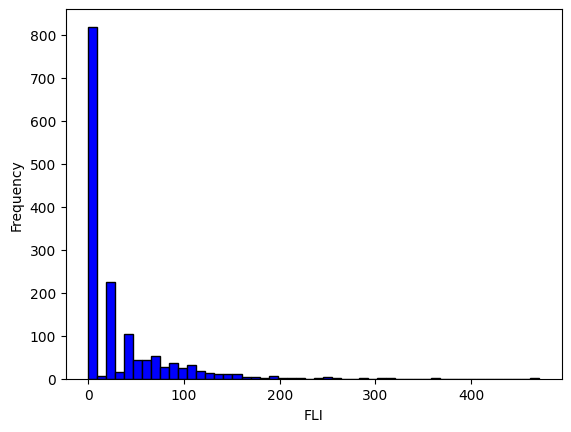

In [191]:
# Look at distribution of CI, CFI and FLI
df_fert = df6.drop_duplicates(subset=["SE_Number", "LactationNumber"])

plt.hist(df_fert['CI'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.hist(df_fert['CFI'], bins=50, color='blue', edgecolor='black')
plt.xlabel('CFI')
plt.ylabel('Frequency')
plt.show()

plt.hist(df_fert['FLI'], bins=50, color='blue', edgecolor='black')
plt.xlabel('FLI')
plt.ylabel('Frequency')
plt.show()

In [192]:
# Thresholds
# Filter for CI values less than or equal to 730 or NaN
df6 = df6[(df6["CI"] <= 730) | (df6["CI"].isna())]

# Filter for CFI values between 20 and 230 (inclusive) or NaN
df6 = df6[(df6["CFI"].between(20, 230, inclusive="both")) | (df6["CFI"].isna())]

# Filter for FLI values less than or equal to 365 or NaN
df6 = df6[(df6["FLI"] <= 365) | (df6["FLI"].isna())]

df6.to_csv("../data/CowData/fertilityDF_W_MY_filtered.csv", index=False)

In [193]:
print(f"No. observations in fertilityDF_W_MY_filtered.csv.csv: {df6.shape}")

test = df6.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in filtered data: {test.shape}")
test = df6.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in filtered data: {test.shape}")
test = df6.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in filtered data: {test.shape}")

No. observations in fertilityDF_W_MY_filtered.csv.csv: (3215, 72)
No. inseminations in filtered data: (1789, 72)
No. lactations in filtered data: (1516, 72)
No. cows in filtered data: (984, 72)


Minimum and maximum threshold on specific classical fertility traits
- i.e. if not within range, put to missing

In [194]:
# Load unfiltered data to check distribution
fert_df = pd.read_csv("../Data/CowData/fertilityDF_W_MY.csv", low_memory=False)
fert_df = fert_df.drop_duplicates(subset=["SE_Number", "LactationNumber"])

In [195]:
# Look at distributions
summary_stats = fert_df['GL'].describe()
percentiles = np.percentile(fert_df['GL'].dropna(), [1, 5, 10, 90, 95, 99])

print("Descriptive Statistics:\n", summary_stats)
print("\nPercentiles (1%, 5%, 10%, 90%, 95%, 99%):", percentiles)

Descriptive Statistics:
 count    1260.000000
mean      272.807937
std        53.250092
min      -171.000000
25%       276.000000
50%       280.000000
75%       283.000000
max       632.000000
Name: GL, dtype: float64

Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [-79.28 269.   273.   287.   288.   295.  ]


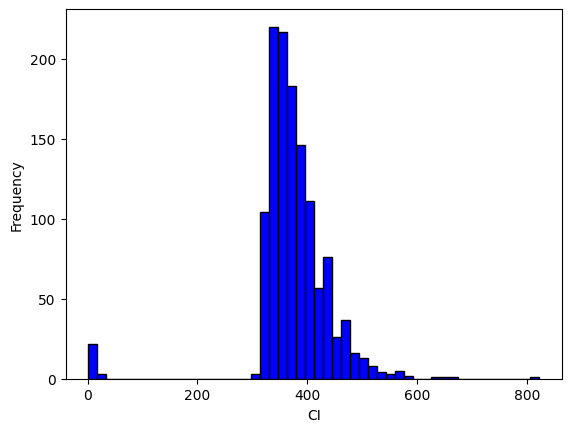

In [196]:
plt.hist(fert_df['CI'], bins=50, color='blue', edgecolor='black')
plt.xlabel('CI')
plt.ylabel('Frequency')
plt.show()

In [197]:
# Put thresholds on traits: Define the valid range and set outside this range to missing
df6 = pd.read_csv("../Data/CowData/fertilityDF_W_MY_filtered.csv", low_memory=False)

# CFI: 79 +- 35 => 20-230d according to NAV (min 32, max 404) Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [ 37.  43.  48. 121. 146. 208.]
CFI_min = 20
CFI_max = 230

df6.loc[(df6["CFI"] < CFI_min) | (df6["CFI"] > CFI_max), "CFI"] = np.nan

# CLI: 107 +- 55 => 20-217 if CFI min 20 and FLI 0 then CLI also 20d, 217 = 107+(55*2)
#   (min 22, max 531) Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [ 39.    48.    53.   181.   213.   293.46]
CLI_min = 20
CLI_max = 217

df6.loc[(df6["CLI"] < CLI_min) | (df6["CLI"] > CLI_max), "CLI"] = np.nan

# FLI: 28 +- 45 => 0-365d according to NAV (min 0, max 471) Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [  0.     0.     0.    87.   115.   194.46]
FLI_min = 0
FLI_max = 365

df6.loc[(df6["FLI"] < FLI_min) | (df6["FLI"] > FLI_max), "FLI"] = np.nan

# CI: 373 +- 72 => 301-730d 301d according to 373-72, 730d according to NAV
#   (min 1, max 822) Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [  2.59 322.   329.   442.   472.   545.64] 
CI_min = 301
CI_max = 730

df6.loc[(df6["CI"] < CI_min) | (df6["CI"] > CI_max), "CI"] = np.nan

# GL: 260 - 302 according to NAV. Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [-79.28 269.   273.   287.   288.   295.  ]
GL_min = 260
GL_max = 302

df6.loc[(df6["GL"] < GL_min) | (df6["GL"] > GL_max), "GL"] = np.nan

In [198]:
# Double check distributions after handling outliers
summary_stats = df6['CFI'].describe()
percentiles = np.percentile(df6['CFI'].dropna(), [1, 5, 10, 90, 95, 99])

print("Descriptive Statistics:\n", summary_stats)
print("\nPercentiles (1%, 5%, 10%, 90%, 95%, 99%):", percentiles)

Descriptive Statistics:
 count    3215.000000
mean       76.450700
std        31.171724
min        33.000000
25%        55.000000
50%        68.000000
75%        90.000000
max       226.000000
Name: CFI, dtype: float64

Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [ 37.    42.    47.   116.   137.   192.86]


In [199]:
# Save filtered data
df6.to_csv("../Data/fertilityDF_W_MY_filtered.csv", index=False)

# Descriptive statistics - filtered data

In [200]:
# MILKING RECORDS
df_lact = pd.read_csv("../Data/fertilityDF_W_MY_filtered.csv", low_memory=False)

count_my_rec = df_lact.groupby(["Parity"])["InseminationDate"].count().reset_index()
print(f"No. of insemination records divided over parities: \n", count_my_rec.to_string(index=False))

count_my_rec = df_lact.groupby(["Parity", "Breed"])["InseminationDate"].count().reset_index()
print(f"No. of insemination records divided over parities and breeds: \n", count_my_rec.to_string(index=False))

# By parity
for_my_rec5 = df_lact.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of parities in file: {for_my_rec5.shape}")  

count_my_rec = for_my_rec5.groupby(["Parity", "Breed"])["SE_Number"].count().reset_index()
print(f"No. of parities from NRDC, SH: \n", count_my_rec.to_string(index=False))

# By cows
for_my_rec4 = df_lact.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows in file: {for_my_rec4.shape}") 

for_my_rec5 = for_my_rec4.drop_duplicates(subset=["SE_Number"])
count_my_rec = for_my_rec5.groupby(["Breed"])["SE_Number"].count().reset_index()
print(f"No. of cows from NRDC, SH: \n", count_my_rec.to_string(index=False))

# Herd info
df_lact = pd.read_csv("../Data/fertilityDF_W_MY_filtered.csv", low_memory=False)
df_lact = df_lact.drop_duplicates(subset=["FarmName_Pseudo"])
col_keep = ["FarmName_Pseudo"]
df_lact = df_lact[col_keep]
print(df_lact.shape)
print(f"Herds in filtered data: \n", df_lact.to_string(index=False))

No. of insemination records divided over parities: 
  Parity  InseminationDate
    1.0              1222
    2.0               890
    3.0              1103
No. of insemination records divided over parities and breeds: 
  Parity Breed  InseminationDate
    1.0  NRDC               410
    1.0   SLB               812
    2.0  NRDC               291
    2.0   SLB               599
    3.0  NRDC               370
    3.0   SLB               733
No. of parities in file: (1516, 72)
No. of parities from NRDC, SH: 
  Parity Breed  SE_Number
    1.0  NRDC        190
    1.0   SLB        366
    2.0  NRDC        144
    2.0   SLB        278
    3.0  NRDC        185
    3.0   SLB        353
No. of cows in file: (984, 72)
No. of cows from NRDC, SH: 
 Breed  SE_Number
 NRDC        346
  SLB        638
(7, 1)
Herds in filtered data: 
 FarmName_Pseudo
       a624fb9a
       5b581702
       5c06d92d
       a756bc39
       ad0a39f5
       6d38bc90
       f454e660
